In [1]:
import requests
import csv
import os
import warnings
from tqdm import tqdm 

import time
from datetime import datetime
from isodate import datetime_isoformat


import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

warnings.simplefilter(action='ignore', category=FutureWarning)

# ddi - Mini-Challenge zu LE3, NoSQL
Roman Studer, Simon Luder

## Use Case
<p align="center">
  <img src="./data/images/Konzept.png" alt="drawing" width="900"/>
</p>

Wir unterbreiten den Vorschlag eine NoSQL Datenbank (MongoDB) als Data Lake für die Speicherung von Time Series Daten zu verwenden und die Analyse besagter Daten auf einer Time-Series Datenbank durchzuführen. Die Analyse dieser Daten kann mittels einer auf Time Series optimierte Datenbank auf Abruf geschehen. Als Beispiel verwenden wir als Datenquelle openSenseMap, welche Messwerte und Sensormetainformationen über eine API zur Verfügung stellt. Ein aktiver Sensor sendet periodisch (je nach Sensor alle paar Sekunden oder Minuten) einen Messwert. Bei einem Intervall von 10 Sekunden sendet ein Sensor pro Jahr 3'153'600 Datenpunkte. 

OpenSenseMap erlaubt es ein ganzes Gebiet (Mittels Angabe von Breiten- und Längengrad) zu überwachen. Die Anzahl Sensoren, sowie deren Attribute kann sich über die Zeit ändern. Wenn zum Beispiel ein neuer Sensor im gleichen Gebiet in Betrieb genommen wird. Daher ist die Datenspeicherung in einer NoSQL, schemenlosen Datenbank geeignet. MongoDB ist dabei aufgrund des flexigblem Schema und einfacher horizontaler Skalierung gut geeignet. Dadurch sind wir auf Änderungen in den durch die API erhaltenen Attributen, sowie auf grosse Änderungen in der Datenmenge gewappnet. MongoDB ist allerdins nicht für die Analyse von Time Series geeignet. InfluxDB, eine Time Series Datenbank, ist für Time Series Daten optimiert und kann schnell Aggregationen über eine grosse Anzahl von Datenpunkten (über Timestamp Indexiert) durchführen. Ein Beispiel wäre ein Moving Average mit kleinem Fenster über mehrere Millionen Datenpunkte.

Weiter existiert ein MongoDB-Plugin auf Telegraf welche die Performance der MongoDB überwachen kann. Somit kann das Monitoring über Influx betrieben werden. 

Im Anschluss setzen wir sowohl eine MongoDB als auch eine InfluxDB auf. Über ein Script laden wir alle Sensordaten auf dem Gelände der ETH-Zürich, welche OpenSenseMap zur Verfügung stellt herunter und speichern diese in der MongoDB. Im Anschluss messen wir die Zeit für Aggregationen bei steigenden Datenpunkten einzeln für beide Datenbanken, sowie für den Fall wenn MongoDB als Datalake verwendet wird. Dadurch können wir einen Punkt identifizieren ab dem es nicht mehr sinnvoll ist nur mit einer MongoDB zu arbeiten, sondern die InfluxDB zur Analyse hinzuzuziehen.

### Vergleich MongoDB vs. InfluxDB

## Datenmodell

## Load Data

In [2]:
#get list of ifu boxes at eth
url = 'https://api.opensensemap.org/boxes?'
bbox = '8.50269672304309, 47.40598032642525,  8.512126181507432, 47.4113301084323 ' # boundary box around eth zurich
boxes = requests.get(url, params={'bbox':bbox, 'full':'false'}).json()

In [3]:
from_date = '2021-04-25T10:05:49.581Z'
to_date = '2021-05-02T10:05:49.581Z'
data_format = 'csv'

In [4]:

for box in tqdm(boxes):
    box_id = box['_id']
    box_name = box['name']
    location = box['currentLocation']['coordinates']
    lat, lon = location[0], location[1]
    for sensor in box['sensors']:
        try:
            sensor_id = sensor['_id']
            sensor_name = sensor['title']
            sensor_name.replace('/', '')
            sensor_unit = sensor['unit']
        except:
            pass
        
        #url = f'https://api.opensensemap.org/boxes/{box_id}/data/{sensor_id}?format={data_format}&download=true'
        url = f'https://api.opensensemap.org/boxes/{box_id}/data/{sensor_id}?from-date={from_date}&to-date={to_date}&download=true&format={data_format}'
        r = requests.get(url, stream=True)
        if (len(r.text) > 16): # check if sensor returns values (header has length 16)
            with open(f'./data/{box_name}_{sensor_name}.csv', 'wb') as f:
                for _, line in enumerate(r.iter_lines()):
                    if _ == 0: # define header
                        line = 'box_name,sensor_name,box_id,sensor_id,lat,lon,unit,current_time,value\n'
                    else:
                        time, value = (line.decode("utf-8").split(','))
                        time = time.replace('T', ' ').replace('Z', '')
                        time = datetime.strptime(time, '%Y-%m-%d %H:%M:%S.%f').strftime('%Y-%m-%d %H:%M:%S')
                        line= f'{box_name},{sensor_name},{box_id},{sensor_id},{lat},{lon},{sensor_unit},{time},{value}\n'
                    f.write(line.encode())

100%|██████████████████████████████████████████████████████████████████████████████████| 82/82 [02:52<00:00,  2.10s/it]


## Setup MongoDB

In [5]:
#!pip install pymongo
from pymongo import MongoClient
import pymongo
import datetime as dt

### Prepare data

In [6]:
def csv_to_dict(path, file):
    '''converts a csv file to a dictionary'''
    data = pd.read_csv(path + file)
    pd.to_datetime(data.current_time, format="%Y-%m-%d %H:%M:%S")
    document = []
    for i in range(len(data)):
        dictionary = dict()
        dictionary["_id"] = file.replace('.csv', '_{}'.format(i))
        dictionary["box_name"] = data["box_name"][0]
        dictionary["sensor_name"] = data["sensor_name"][0]
        dictionary["box_id"] = data["box_id"][0]
        dictionary["sensor_id"] = data["sensor_id"][0]
        dictionary["lat"] = data["lat"][0]
        dictionary["lon"] = data["lon"][0]
        dictionary["unit"] = data["unit"][0]
        dictionary["value"] = data["value"][i]
        dictionary["timestamp"] = dt.datetime.strptime(data["current_time"][i], '%Y-%m-%d %H:%M:%S')
        document.append(dictionary)
                   
#     dictionary["measurments"] = dict(zip(data["current_time"], data["value"]))
#     dictionary["measurments"] = {["timestamp" : data["current_time"], 
#                                      "data" : data["value"]}

    return document

In [7]:
times = pd.date_range(from_date,to_date,freq='4h')

def to_RFC3339Date(x):
    x = str(x)
    x = x.replace(' ','T')
    x = x.replace('000+00:00','Z')
    return x

times = [i for i in times][1:] # remove first time as it is equal to from_date
times = [to_RFC3339Date(i) for i in times]

In [8]:
len(times)

42

### Create db

In [9]:
mongo_client = pymongo.MongoClient('localhost', 27017)
mongo_db = mongo_client["ddi_mc2"]

### Populate db

In [10]:
VERBOSE = False
path = './data/'
for file in tqdm(os.listdir("./data")):
#     print(file.split("_")[0])
    if file.endswith('.csv'): # check for filetype
        if not mongo_db[file.split("_")[0]].count_documents({"_id":file.replace('.csv', '')}) > 0:
            dictionary = csv_to_dict(path, file)
            for document in dictionary:
                mongo_db[file.split("_")[0]].insert_one(document)
            if VERBOSE:
                print("populate:", file)

100%|████████████████████████████████████████████████████████████████████████████████| 161/161 [05:44<00:00,  2.14s/it]


### List all Sensor-Boxes within the MongoDB

In [11]:
mongo_db.list_collection_names()

['IKG Particulate Matter',
 'IfU SenseBox2021 04 A',
 'ifU SenseBox2021 10A',
 'IfU SenseBox2021 dab',
 'IfU SenseBox2021 12',
 'IfU SenseBox2021 5A',
 'IfU SenseBox2021 2B',
 'IfU SenseBox2021 1A',
 'IfU SenseBox2021 9A',
 'IfU SenseBox2021 5B',
 'IfU SenseBox2021 04 B',
 'IfU SenseBox2021 8B',
 'IfU SenseBox2021 11A',
 'IfU SenseBox 7A',
 'IFU Sensebox2021 2A',
 'IfU SenseBox2021 3A']

### List all Sensors of a Sensor-Box

In [12]:
boxes = mongo_db['IFU Sensebox2021 2A'].find().distinct('sensor_name')[0:10]
boxes

['Luftfeuchte 2-SHT31 Nr.2',
 'Luftfeuchte 2-SHT85 Nr.0',
 'Luftfeuchte 2-SHT85 Nr.1',
 'Luftfeuchte 2-SHT85 Nr.2',
 'Luftfeuchtigkeit 2-BME680',
 'Lufttemperatur 2-BME680',
 'Lufttemperatur 2-SHT31 Nr.2',
 'Lufttemperatur 2-SHT85 Nr.0',
 'Lufttemperatur 2-SHT85 Nr.1',
 'Lufttemperatur 2-SHT85 Nr.2']

In [13]:
# list(mongo_db['IFU Sensebox2021 2A'].find({"sensor_name": "Lufttemperatur 2-BME680",  
#                                              "timestamp": {"$gt": datetime.strptime('2021-04-25 00:00:00.000', '%Y-%m-%d %H:%M:%S.%f'), 
#                                                            "$lt": datetime.strptime('2021-05-02 00:05:00.000', '%Y-%m-%d %H:%M:%S.%f')}}))


In [14]:
import time
sensor_name = "Lufttemperatur 2-BME680"
box_name = "IFU Sensebox2021 2A"

mean_runtimes = []
std_runtimes = []
n_init = 10

for i in tqdm(range(len(times))):   
    runtimes = [] 
    n_datepoints = []
    
    for _ in range(n_init):

        start = time.perf_counter()

        query = list(mongo_db[box_name].aggregate([
                {
                "$match": {
                "sensor_name": sensor_name,
                "timestamp": {"$gte": datetime.strptime(from_date, '%Y-%m-%dT%H:%M:%S.%fZ'), 
                              "$lte": datetime.strptime(times[i], '%Y-%m-%dT%H:%M:%S.%fZ')}}
                },
                {
                    "$group": {
                        "_id": {
                        "minute": {"$minute": "$timestamp"},
                        "hour": {"$hour": "$timestamp"},
                        "day": {"$dayOfMonth": "$timestamp"},
                        "month": {"$month": "$timestamp"},
                        "year": {"$year": "$timestamp"} 
                        }, 
                    "mean": {"$avg": "$value"}  
                }}
            ]))

        end = time.perf_counter()

        runtimes.append(end-start)
    mean_runtimes.append(np.mean(runtimes))
    std_runtimes.append(np.std(runtimes))

100%|██████████████████████████████████████████████████████████████████████████████████| 42/42 [00:45<00:00,  1.09s/it]


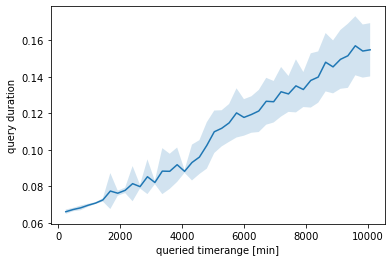

In [15]:
fmt = '%Y-%m-%dT%H:%M:%S.%fZ'
time_diff = [(datetime.strptime(i, fmt)-datetime.strptime(from_date, fmt)) for i in times]
time_diff = [time.total_seconds()/60 for time in time_diff]

plt.plot(time_diff, mean_runtimes)
plt.fill_between(time_diff, np.subtract(mean_runtimes,std_runtimes), np.add(mean_runtimes,std_runtimes), alpha=.2)
plt.xlabel("queried timerange [min]")
plt.ylabel("query duration")
plt.show()

In [16]:
# list(mongo_db[box_name].aggregate([
#     {
#     "$match": {
#     "sensor_name": sensor_name,
#     "timestamp": {"$gte": datetime.strptime(from_date, '%Y-%m-%dT%H:%M:%S.%fZ'), 
#                   "$lte": datetime.strptime(times[2], '%Y-%m-%dT%H:%M:%S.%fZ')}}
#     },
#     {
#         "$group": {
#             "_id": {
#             "minute": {"$minute": "$timestamp"},
#             "hour": {"$hour": "$timestamp"},
#             "day": {"$dayOfMonth": "$timestamp"},
#             "month": {"$month": "$timestamp"},
#             "year": {"$year": "$timestamp"} 
#             }, 
#             "mean": {"$avg": "$value"},
#             "timestamp": { "$max": "$timestamp"}
            
#     }}
# ]))

## Setup InfluxDB 

Die Influx-Datenbank kann über die Website [influxdata.com](influxdata.com) heruntergeladen werden. Nach der Installation muss ein Administratorenkonto eingerichtet werden. Weiter muss für die Verwendung in unserem Beispiel ein "Bucket" erstellt werden, welcher die Sensordaten halten wird. Diesen bennen wir "ddi" und belassen die Retention Policy bei "never". So wird der Bucket nicht nach einer definierten Zeitdauer automatisch gelöscht. Für die Kommunikation zur Datenbank über Python muss die Bibliothek `influxdb_client` installiert und importiert werden. Dies Bibiliothek dient als Client und ist in etwa mit dem Cursor für eine Postgres-Datenbank zu vergleichen. Beachten Sie dass der Zugriff authorisiert sein muss. Dazu muss ein Token für den jeweiligen Bucket erstellt werden. Dieser kann im Influx-Dashboard unter "Data -> Token" erstellt und kopiert werden. Möchten sie dieses Notebook durchlaufen lassen, müssen sie einen eigenen Token erstellen und in der unteren Zeile bei der Variable `token` einfügen.

In [17]:
# !pip install influxdb-client
from datetime import datetime

from influxdb_client import InfluxDBClient, Point, WritePrecision
from influxdb_client.client.write_api import SYNCHRONOUS

# You can generate a Token from the "Tokens Tab" in the UI
token = "uZei_UmVg7IGcllVQdvKbmbCjwx5s0pe7KfTafVspsL0qGWIg6fmB34JNwWmsEGdt9aFr2Qio6ltOB9_ZrCDDw=="
org = "ddi"
bucket = "ddi"

client = InfluxDBClient(url="http://localhost:8086", token=token, profilers=True)
write_api = client.write_api(write_options=SYNCHRONOUS)

# RS: uZei_UmVg7IGcllVQdvKbmbCjwx5s0pe7KfTafVspsL0qGWIg6fmB34JNwWmsEGdt9aFr2Qio6ltOB9_ZrCDDw==
# SL: AW-zLqzOTpQW4sRYaKbdXpSxBLkxT8rT-RZA-IS5MYo41RZ40YoOCoNYTyu9S2La5W4KpcDzDgCfj53fk6aZuw==

Die untere Zeile zeigt an dass unsere Verbindung steht wenn "status" = 'pass' ist. Sonst sind wir nicht mit der Datenbank verbunden

In [18]:
client.health()

{'checks': [],
 'commit': '4db98b4c9a',
 'message': 'ready for queries and writes',
 'name': 'influxdb',
 'status': 'pass',
 'version': '2.0.6'}

### Query MongoDB, insert into InfluxDB

In [19]:
# # select box and get all measurements
# col = mongo_db.list_collection_names()
# col

In [20]:
col = "IFU Sensebox2021 2A"

In [21]:
# result = mongo_db[col].find_one({},{'measurments':1}) # select first sensor with field 'measurments'
# result

**Get all sensors within a selected box**

In [22]:
sensor_names = mongo_db[col].find().distinct('sensor_name')
measurment_id = mongo_db[col].find().distinct('_id')
results = []
ts, vs = {}, {}
for j in tqdm(measurment_id):
    sample = mongo_db[col].find_one({'_id':j},{'value', 'timestamp', 'sensor_name', "box_name"})
    indlux_id = "{}_{}".format(sample["box_name"], sample["sensor_name"])
    if indlux_id not in ts.keys():
        ts[indlux_id] = []
        vs[indlux_id] = []
    ts[indlux_id].append(sample["timestamp"].strftime('%Y-%m-%d %H:%M:%S'))
    vs[indlux_id].append(sample["value"])
#       print(ts, vs)
# results[i] = dict(zip(ts, vs))


for key in ts.keys():
    result = dict()
    result["_id"] = key
    result["measurments"] = dict(zip(ts[key], vs[key]))
    results.append(result)

100%|████████████████████████████████████████████████████████████████████████| 162584/162584 [00:51<00:00, 3150.78it/s]


In [23]:
# results[5] # = IFU Sensebox2021 2A_Lufttemperatur 2-BME680'

In [24]:
# for result in tqdm(results):
result = results[5]
for observation in result['measurments'].items():
    point = Point(result['_id'].split('_')[0]) \
      .tag("sensor_name", result['_id'].split('_')[1]) \
      .field("_value", observation[1])\
      .time(datetime.strptime(observation[0], "%Y-%m-%d %H:%M:%S"), WritePrecision.S)

    write_api.write(bucket, org, point)

#### Query InfluxDB

In [25]:
box_name = "IFU Sensebox2021 2A"
sensor_name = "Lufttemperatur 2-BME680"

mean_runtimes = []
std_runtimes = []
n_init = 10

query_api = client.query_api()

for i in tqdm(range(len(times))):   
    runtimes = [] 
    n_datepoints = []
    
    for _ in range(n_init):

        start = time.perf_counter()

        query = f'''
            from(bucket: "ddi")
              |> range(start: time(v: "{from_date}"), stop: time(v: "{times[i]}"))
              |> filter(fn: (r) => r["_measurement"] == "IFU Sensebox2021 2A")
              |> filter(fn: (r) => r["_field"] == "_value")
              |> filter(fn: (r) => r["sensor_name"] == "Lufttemperatur 2-BME680")
              |> aggregateWindow(every: 1m, fn: mean, createEmpty: false)
              |> yield(name: "mean")'''

        table = query_api.query(query, org=org)
        

        end = time.perf_counter()
        
        b = []
        for a in table:
            for record in a.records:
                b.append((record.get_field(), record.get_value()))
        
        runtimes.append(end-start)
        n_datepoints.append(len(table))
    #print(len(b))
    mean_runtimes.append(np.mean(runtimes))
    std_runtimes.append(np.std(runtimes))

  0%|                                                                                           | 0/42 [00:00<?, ?it/s]


TypeError: object of type 'bool' has no len()

In [ ]:
plt.plot(range(0, len(mean_runtimes)), mean_runtimes)
plt.fill_between(range(0, len(mean_runtimes)), np.subtract(mean_runtimes,std_runtimes), np.add(mean_runtimes,std_runtimes), alpha=.2)